In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import json
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [ ]:
N_ITER_TARGET = 40
N_ITER_UNTARGET = 10

In [ ]:
# Make text in plots match LaTeX
!wget https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
font_prop = fm.FontProperties(fname='Times New Roman.ttf')
plt.rcParams['font.family'] = font_prop.get_name()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [font_prop.get_name()] + plt.rcParams['font.serif']

--2023-10-12 03:16:12--  https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf [following]
--2023-10-12 03:16:12--  https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf.1’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.07s   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_path = '/content/drive/MyDrive/transfer results/target/resnet/'
attack_names = []
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
for txt_file in txt_files:
    attack_name = txt_file.split('_')[0]
    attack_names.append(attack_name)

color_map = sns.color_palette(n_colors=len(attack_names))
ATTACK_COLOR_MAP = {name: color_map[i] for i, name in enumerate(attack_names)}

In [ ]:
def process_file(file_path, ignore_first: bool = False, local_metrics: bool = False):
    data_dict = {}
    with open(file_path) as f:
        batch = -1
        iteration = -1
        time = -1
        asr = -1
        basic_check = 1

        for line in f:
            if basic_check < 0:
                raise ValueError("Something wrong with file: batch size appears twice")
            if 'batch size:' in line:
                basic_check -= 1

            if 'batch:' in line:
                batch = int(line.split(': ')[1])
                data_dict[batch] = {}
            elif 'iteration:' in line:
                iteration = int(line.split(': ')[1])
            elif 'time:' in line:
                time = float(line.split(': ')[1])
            elif 'ASR:' in line and 'local' not in line:
                asr = float(line.split(': ')[1])
                # Ignore first batch, first iteration if requested (GPU init costs, etc.)
                if ignore_first and batch == 0 and iteration == 0:
                    continue
                data_dict[batch][iteration] = {'time': time, 'ASR': asr}

            # Check for local metrics (if present)
            if local_metrics:
                if 'local ASR:' in line:
                    local_asr = float(line.split(': ')[1])
                    data_dict[batch][iteration]['local_ASR'] = local_asr
                elif 'local loss:' in line:
                    local_loss = float(line.split(': ')[1])
                    data_dict[batch][iteration]['local_loss'] = local_loss

    if local_metrics:
        intermediate_dict = defaultdict(lambda: {'time': [], 'ASR': [], 'local_ASR': [], 'local_loss': []})
    else:
        intermediate_dict = defaultdict(lambda: {'time': [], 'ASR': []})
    for batch_data in data_dict.values():
        for iteration, metrics in batch_data.items():
            intermediate_dict[iteration]['time'].append(metrics['time'])
            intermediate_dict[iteration]['ASR'].append(metrics['ASR'])
            if local_metrics:
                intermediate_dict[iteration]['local_ASR'].append(metrics['local_ASR'])
                intermediate_dict[iteration]['local_loss'].append(metrics['local_loss'])

    average_dict = {}
    num_batches = None
    for iteration, metrics in intermediate_dict.items():
        if len(metrics['time']) != len(metrics['ASR']):
            raise ValueError("Log file has some issues (entries for time not same as entries for ASR)")
        if num_batches is None:
            num_batches = len(metrics['time'])

        if len(metrics['time']) == num_batches:
            # No. of iterations may not be same for all batches towards the end, so ignore them
            if local_metrics:
              average_dict[iteration] = {
                    'time': sum(metrics['time']) / len(metrics['time']),
                    'ASR': sum(metrics['ASR']) / len(metrics['ASR']),
                    'local_ASR': sum(metrics['local_ASR']) / len(metrics['local_ASR']),
                    'local_loss': sum(metrics['local_loss']) / len(metrics['local_loss']),
                }
            else:
                average_dict[iteration] = {
                    'time': sum(metrics['time']) / len(metrics['time']),
                    'ASR': sum(metrics['ASR']) / len(metrics['ASR'])
                }
    return average_dict

In [ ]:
def process_query_file(file_path: str,
                       sort_by: str = "queries",
                       look_for_time: bool = True):
    data_dict = {}

    success, queries, times = [], [], []
    with open(file_path) as f:
        json_data = json.load(f)
        for k, v in json_data.items():
            # Success
            if 'succ:' in v:
                succ_ = v['succ:']
            elif 'succ' in v:
                succ_ = v['succ']
            else:
                raise ValueError('No entry found for succcess')
            success.append(float(succ_))

            # Querues
            if 'num_query' in v:
                queries.append(int(v['num_query']))
            elif 'query' in v:
                queries.append(int(v['query']))
            else:
                raise ValueError('No entry found for queries')

            if look_for_time:
                times.append(float(v['time']))

        num_examples = len(success)
        success = np.array(success)
        queries = np.array(queries)
        if look_for_time:
            times = np.array(times)

        # Now, we want to sort by query (or time) and keep track of ASR as we go along
        if sort_by == "queries":
            sorting_order = np.argsort(queries)
        elif sort_by == "time":
            if not look_for_time:
                raise ValueError("Asked to sort on time, but no time information available!")
            sorting_order = np.argsort(times)
        else:
            raise ValueError("Either sort by queries, or time")

        if look_for_time:
            times = times[sorting_order]
        queries = queries[sorting_order]
        success = 100 * np.cumsum(success[sorting_order]) / num_examples

        j = 0
        time_, asr_ = 0, 0
        average_dict = {}
        if sort_by == "queries":
            for iteration in range(np.max(queries) + 1):
                while j < len(queries) and iteration == queries[j]:
                    if look_for_time:
                        time_ = times[j]
                    asr_ = success[j]
                    j += 1
                average_dict[iteration] = {
                    'time': time_,
                    'ASR': asr_
                }
        else:
          # filler_time, filler_success = np.zeros(np.max(queries) + 1). np.zeros(np.max(queries) + 1)
          # j = 0
          # for i in range(filler_time.shape[0]):
          #     average_dict[i] = {
          #         'time': times[i],
          #         'ASR': success[i]}
          #     while queries[j] >= i:
          #         j += 1
          for i in range(len(times)):
            average_dict[i] = {
                 'time': times[i],
                 'ASR': success[i]
            }
            if look_for_time:
                average_dict[i]['time'] = times[i]
        return average_dict

In [ ]:
def plot(data_dict, axis=None,
         use_markers: bool=True,
         n_first: int = None,
         n_last: int = None,
         mark_iter: int = None,
         across_time: bool = True,
         legend: str = 'auto',
         y_name: str = 'ASR',
         initial_point_val: float = 0,
         color: str = None,
         needs_time_sorting: bool = False,
         linestyle: str = '-'):
    # Separate the data into lists for plotting
    time_values = np.array([val['time'] for val in data_dict.values()])
    asr_values = np.array([val[y_name] for val in data_dict.values()])

    if needs_time_sorting:
      sorting_order = np.argsort(time_values)
      asr_values, time_values = asr_values[sorting_order], time_values[sorting_order]

    if n_first is not None:
      time_values = time_values[:n_first]
      asr_values = asr_values[:n_first]

    if n_last is not None:
      time_values = time_values[-n_last:]
      asr_values = asr_values[-n_last:]

    marker = 'o' if use_markers else ','
    if not across_time:
      time_values = list(range(1, len(time_values) + 1))

    # Artifically add a (0, 0) point
    time_values = [0] + list(time_values)
    asr_values = [initial_point_val] + list(asr_values)

    attack_name = txt_file.split('_')[0]

    color_use = ATTACK_COLOR_MAP[attack_name] if color is None else color
    sns.lineplot(x=time_values, y=asr_values, marker=marker, ax=axis, label=attack_name, color=color_use, legend=legend, linestyle=linestyle)

    if mark_iter:
      # Mark star at given iteration point
      x, y = time_values[mark_iter], asr_values[mark_iter]
      if axis:
        axis.plot(x, y, marker='*', c=color_use, markersize=20)
      else:
        plt.plot(x, y, marker='*', c=color_use, markersize=20)

In [ ]:
def consistency_check(files):
  suffixes = [x.split('.txt')[0].split('_', 1)[1] for x in files]
  # Make sure all files in folder are in fact for the same setting
  if len(set(suffixes)) != 1:
    print(suffixes)
    raise ValueError("Files for different configurations found in the same folder!")

In [ ]:
# Define the list of directory paths
dir_paths = [
    '/content/drive/MyDrive/transfer results/target/resnet/',
    '/content/drive/MyDrive/transfer results/target/vgg/',
    '/content/drive/MyDrive/transfer results/target/densenet/',
    '/content/drive/MyDrive/transfer results/target/inception/'
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()  # Flatten the axis array for easy indexing

# Loop through each directory and plot on a separate subplot
for i, dir_path in enumerate(dir_paths):
    # Get a list of all the text files in the directory
    txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
    consistency_check(txt_files)

    for txt_file in txt_files:
        # Get the average dictionary for the current file
        average_dict = process_file(os.path.join(dir_path, txt_file))

        # Plot data
        plot(average_dict, axis=axs[i])

        # Setting the x-axis to log scale and x-limit for the i-th subplot
        axs[i].set_xscale('log')
        # axs[i].set_xlim(1e-2, 10)  # Set the x-axis limits; starting from 1e-2 because log(0) is undefined

        # Setting the labels, title, legend (with a smaller fontsize), and grid for the i-th subplot
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('ASR(%)')
        axs[i].set_title(f'ASR vs Time ({dir_path.split("/")[-2]})')  # Using the directory name as the title
        axs[i].legend(fontsize=5)  # Setting the font size of the legend to 'x-small'
        axs[i].grid(True)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Define the list of directory paths
dir_paths = [
    '/content/drive/MyDrive/transfer results/untarget/resnet/',
    '/content/drive/MyDrive/transfer results/untarget/vgg/',
    '/content/drive/MyDrive/transfer results/untarget/densenet/',
    '/content/drive/MyDrive/transfer results/untarget/inception/'
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()  # Flatten the axis array for easy indexing

# Loop through each directory and plot on a separate subplot
for i, dir_path in enumerate(dir_paths):
    # Get a list of all the text files in the directory
    txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
    consistency_check(txt_files)

    for txt_file in txt_files:
        # Get the average dictionary for the current file
        average_dict = process_file(os.path.join(dir_path, txt_file))

        # Plot data
        plot(average_dict, axis=axs[i])

        # Setting the x-axis to log scale and x-limit for the i-th subplot
        axs[i].set_xscale('log')
        # axs[i].set_xlim(1e-2, 10)  # Set the x-axis limits; starting from 1e-2 because log(0) is undefined

        # Setting the labels, title, legend (with a smaller fontsize), and grid for the i-th subplot
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('ASR(%)')
        axs[i].set_title(f'ASR vs Time ({dir_path.split("/")[-2]})')  # Using the directory name as the title
        axs[i].legend(fontsize=5)  # Setting the font size of the legend to 'x-small'
        axs[i].grid(True)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Define the list of directory paths
dir_paths = [
    '/content/drive/MyDrive/transfer results/target/resnet/',
    '/content/drive/MyDrive/transfer results/target/vgg/',
    '/content/drive/MyDrive/transfer results/target/densenet/',
    '/content/drive/MyDrive/transfer results/target/inception/'
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()  # Flatten the axis array for easy indexing

for i, dir_path in enumerate(dir_paths):
    txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
    consistency_check(txt_files)

    for j, txt_file in enumerate(txt_files):
        # Get the average dictionary for the current file
        average_dict = process_file(os.path.join(dir_path, txt_file))

        # Plot data
        plot(average_dict, axis=axs[i])

        # Setting properties for the i-th subplot
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('ASR(%)')
        axs[i].set_title(f'ASR vs Time ({dir_path.split("/")[-2]})')
        # axs[i].set_xscale('log')
        # axs[i].set_xlim(1e-2, 10)
        axs[i].legend(fontsize='x-small')
        axs[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Define the list of directory paths
dir_paths = [
    '/content/drive/MyDrive/transfer results/untarget/resnet/',
    '/content/drive/MyDrive/transfer results/untarget/vgg/',
    '/content/drive/MyDrive/transfer results/untarget/densenet/',
    '/content/drive/MyDrive/transfer results/untarget/inception/'
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()  # Flatten the axis array for easy indexing

# Loop through each directory and plot on a separate subplot
for i, dir_path in enumerate(dir_paths):
    # Get a list of all the text files in the directory
    txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
    consistency_check(txt_files)

    for j, txt_file in enumerate(txt_files):
        # Get the average dictionary for the current file
        average_dict = process_file(os.path.join(dir_path, txt_file))

        # Plot data
        plot(average_dict, axis=axs[i])

        # Setting the labels, title, legend (with a smaller fontsize), and grid for the i-th subplot
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('ASR(%)')
        axs[i].set_title(f'ASR vs Time ({dir_path.split("/")[-2]})')  # Using the directory name as the title

        # Setting the x-axis to log scale and x-limit for the i-th subplot
        # axs[i].set_xscale('log')
        # axs[i].set_xlim(1e-2, 10)  # Set the x-axis limits; starting from 1e-2 because log(0) is undefined

        axs[i].legend(fontsize='x-small')  # Setting the font size of the legend to 'x-small'
        axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
plt.xscale('log')
plt.xlim(0, 10)


In [ ]:
# Get the path to the directory with the text files
dir_path = '/content/drive/MyDrive/transfer results/target/resnet/'

# Get a list of all the text files in the directory
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
consistency_check(txt_files)

# Create a bigger figure
plt.figure(figsize=(12, 8))

# Loop through each text file and plot the data
for txt_file in txt_files:
    # Get the average dictionary for the current file
    average_dict = process_file(os.path.join(dir_path, txt_file))

    # Plot data
    plot(average_dict, use_markers=False)

# Setting the labels, title, legend (with smaller fontsize), and grid
plt.xlabel('Time (s)')
plt.ylabel('ASR(%)')
plt.title('ASR vs Time')
plt.legend(fontsize='small')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# dir_path = '/content/drive/MyDrive/transfer results/timed/untarget/ens_inception/'
dir_path = '/content/drive/MyDrive/transfer results/timed/target/resnet/'
# dir_path = '/content/drive/MyDrive/transfer results/untarget/inception/'

# Get a list of all the text files in the directory
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
consistency_check(txt_files)

# Create a bigger figure
plt.figure(figsize=(12, 8))

# Loop through each text file and plot the data
for txt_file in txt_files:
    # Get the average dictionary for the current file
    average_dict = process_file(os.path.join(dir_path, txt_file))

    # Plot data
    plot(average_dict, use_markers=False, mark_iter=100)

# Setting the labels, title, legend (with smaller fontsize), and grid
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('ASR(%)', fontsize=12)
# plt.legend(fontsize='small')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=6, fontsize=12)
plt.grid(True)
# plt.xscale('log')

# savename = 'timed_untargeted_ens_inception'
savename = 'timed_targeted_resnet_incomplete'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/{savename}.pdf', bbox_inches='tight')

### Figure 1: Top-k interactive attacks

<Figure size 1920x1440 with 0 Axes>

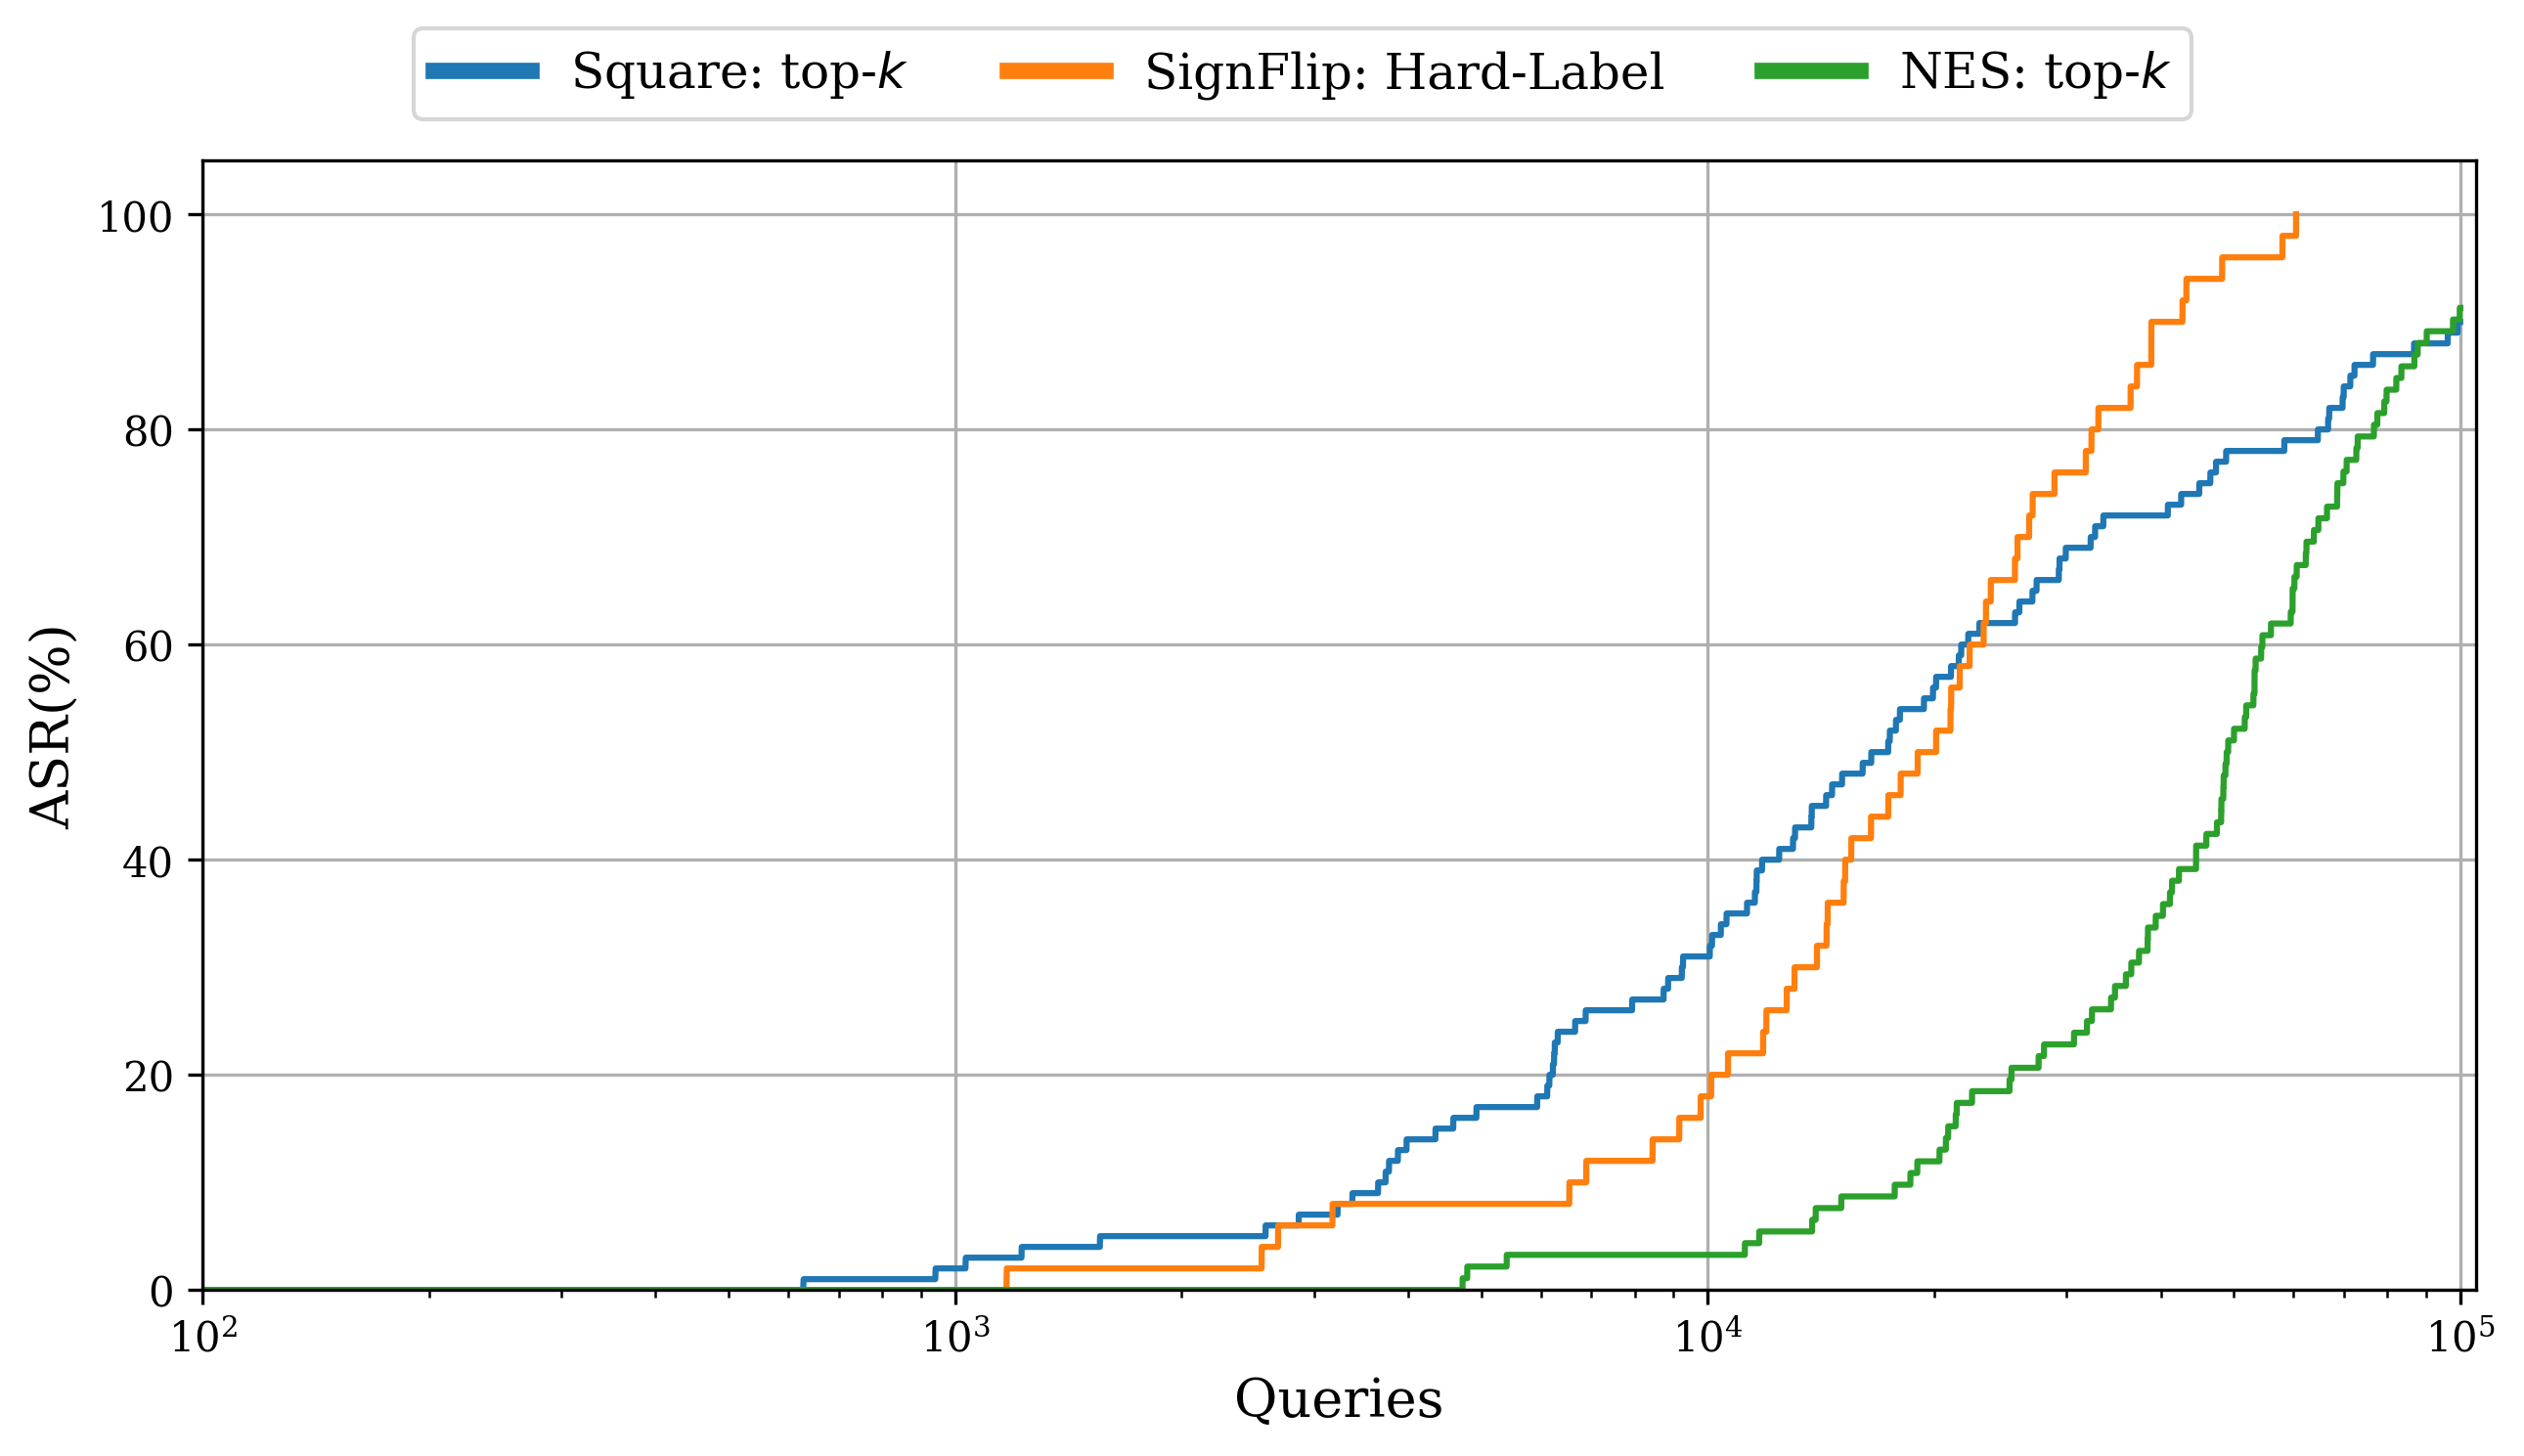

In [ ]:
plt.clf()
dir_path = '/content/drive/MyDrive/transfer results/query result/old_fig1'

target_model = '_inceptionv3'
mode = '_target'

name_mapping = {
    "NES": r"NES: top-$\it{k}$",
    "SignFlip": r"SignFlip: Hard-Label",
    "Square": r"Square: top-$\it{k}$"
}

# Figure size (shorter in height)
plt.figure(figsize=(10, 5))

names_seen = []
# Get a list of all the json files in the directory
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]

# Loop through each text file and plot the data
for i, txt_file in enumerate(txt_files):
    if not (mode in txt_file and target_model in txt_file):
        continue

    # Keep track of attacks actually present
    names_seen.append(txt_file.split("_")[0])

    # Get the average dictionary for the current file (sorted by queries)
    average_dict = process_query_file(os.path.join(dir_path, txt_file), sort_by="queries", look_for_time=False)

    # Plot data (same queries)
    plot(average_dict, use_markers=False, across_time=False, legend=False, color=f'C{i}')

# Setting labels
plt.xlabel(r'Queries', fontsize=13)
plt.ylabel(r'ASR(%)', fontsize=13)

# Same ASR range
plt.ylim(0, 105)
plt.grid(True)

plt.xlim(10**2, None)

# Log scale for queries
plt.xscale('log')

# Custom legend (since seaborn does not recognize clash and labels separately for same attack names)
legend_lines, legend_names = [], []
for i, name in enumerate(names_seen):
    legend_lines.append(Line2D([0], [0], color=f"C{i}", lw=4))
    legend_names.append(name_mapping[name])

# Space adjustment
# plt.subplots_adjust(wspace=0.1, hspace=0)

# Legend plot
plt.figlegend(legend_lines, legend_names,
             loc='upper center', bbox_to_anchor=(0.5, 0.97),
             borderaxespad=0, ncol=3, fontsize=12)

savename = 'topk_comparison'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/paper/{savename}.pdf', bbox_inches='tight')

### Figure 2: DenseNet (targeted) : same iters v/s same runtime

<Figure size 1920x1440 with 0 Axes>

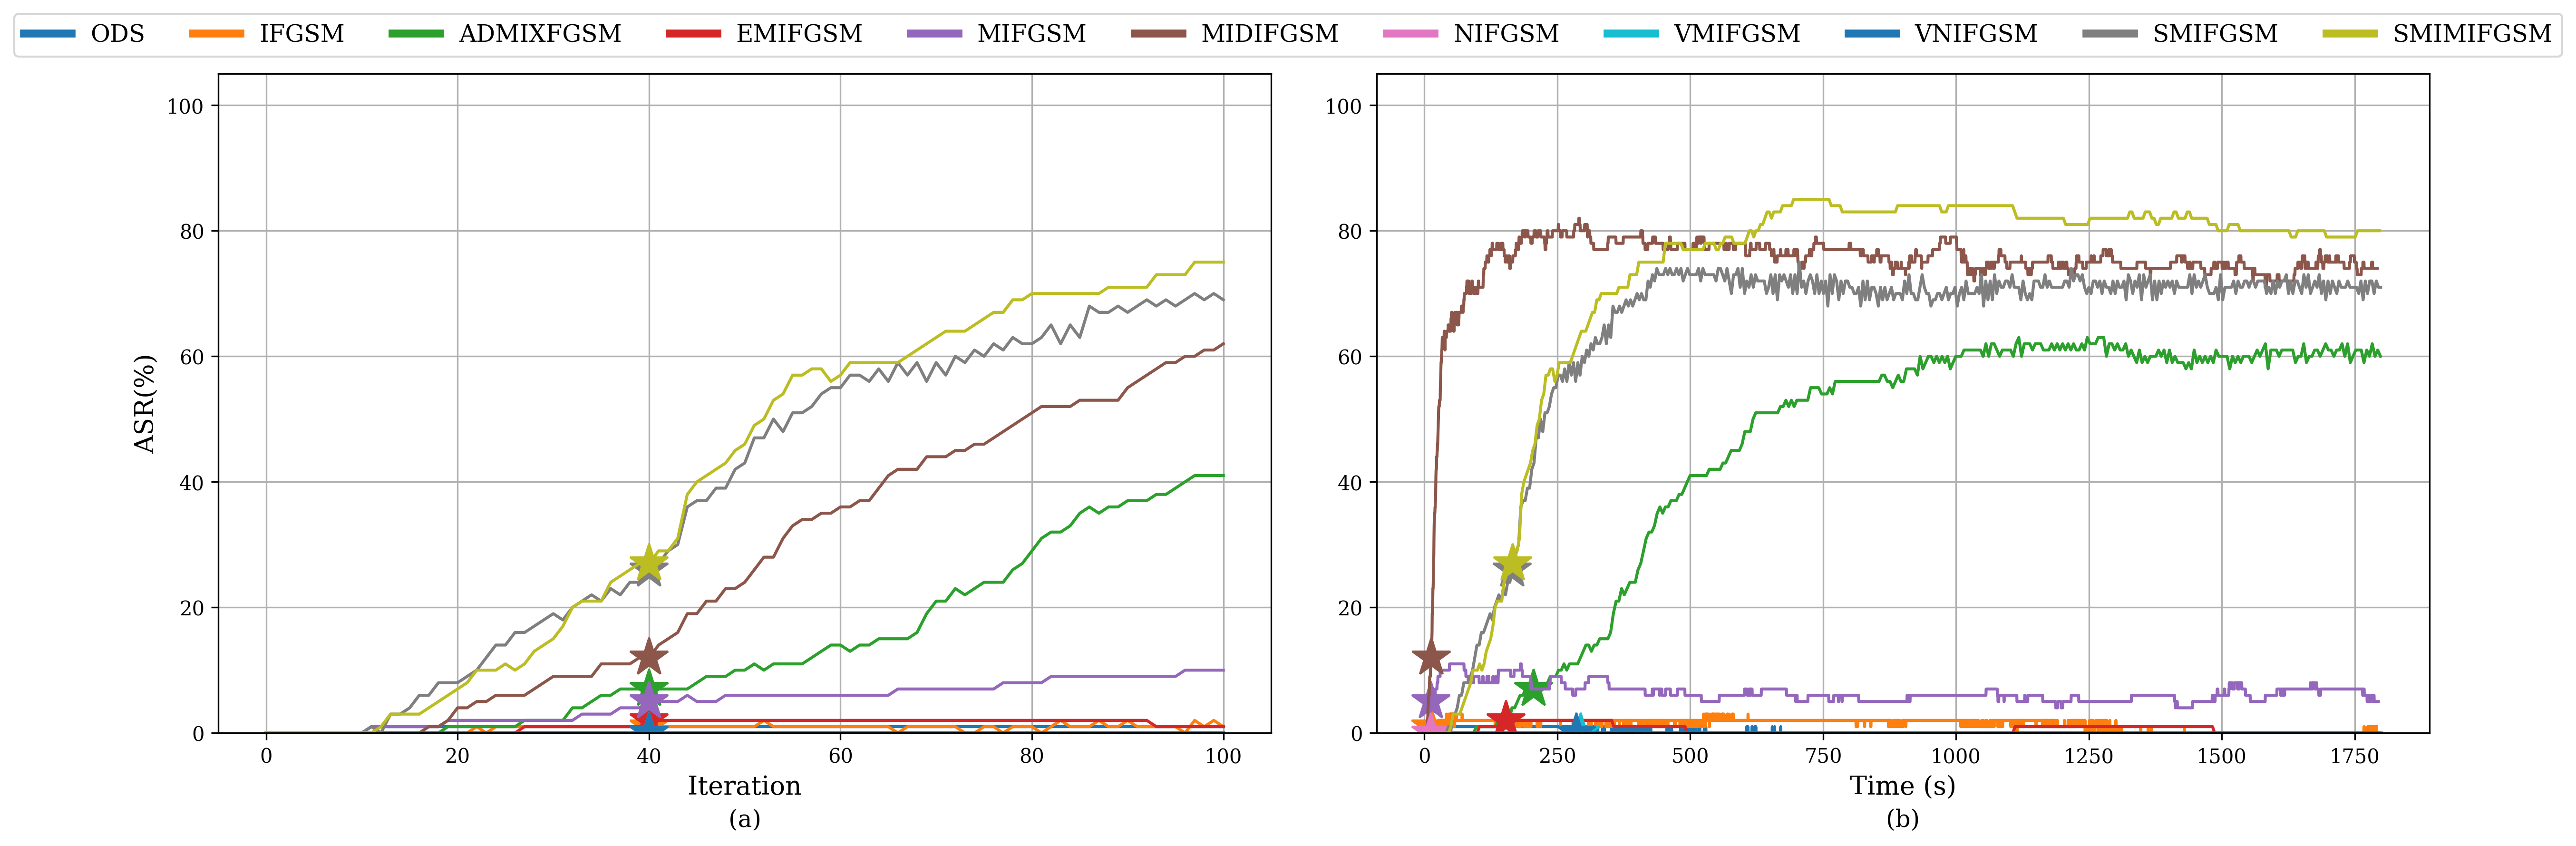

In [ ]:
plt.clf()
# dir_path = '/content/drive/MyDrive/transfer results/timed/untarget/ens_inception/'
dir_path = '/content/drive/MyDrive/transfer results/timed/target/densenet/'

# Get a list of all the text files in the directory
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
consistency_check(txt_files)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.ravel()  # Flatten the axis array for easy indexing

# Loop through each text file and plot the data
names_seen = []
for txt_file in txt_files:
    # Keep track of attacks actually present
    names_seen.append(txt_file.split("_")[0])

    # Get the average dictionary for the current file
    average_dict = process_file(os.path.join(dir_path, txt_file))

    # Plot data (same iters)
    plot(average_dict, axis=axs[0], use_markers=False, n_first=100, mark_iter=N_ITER_TARGET, across_time=False, legend=False)

    # Plot data (same time)
    plot(average_dict, axis=axs[1], use_markers=False, mark_iter=N_ITER_TARGET, across_time=True, legend=False)

# Setting labels
axs[0].set_xlabel('Iteration', fontsize=13)
axs[1].set_xlabel('Time (s)', fontsize=13)
axs[0].set_ylabel('ASR(%)', fontsize=13)

# Same ASR range
axs[0].set_ylim(0, 105)
axs[1].set_ylim(0, 105)
axs[0].grid(True)
axs[1].grid(True)

# Caption titles
axs[0].set_title('(a)', y=-0.16)
axs[1].set_title('(b)', y=-0.16)

# Custom legend (since seaborn does not recognize clash and labels separately for same attack names)
legend_lines, legend_names = [], []
for name in names_seen:
  legend_lines.append(Line2D([0], [0], color=ATTACK_COLOR_MAP[name], lw=4))
  legend_names.append(name)

# Space adjustment
plt.subplots_adjust(wspace=0.1, hspace=0)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 0.95),
              borderaxespad=0, ncol=11, fontsize=12)

savename = 'same_iters_vs_same_time_targeted_densenet'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/paper/{savename}.pdf', bbox_inches='tight')

### Figure 3: DenseNet (untargeted & targeted) : ASR with metrics from local models

SMIMIFGSM_transfer_target_densenet201_eps8.txt
SMIMIFGSM_transfer_untarget_advinceptionv3_eps16.txt


<Figure size 1920x1440 with 0 Axes>

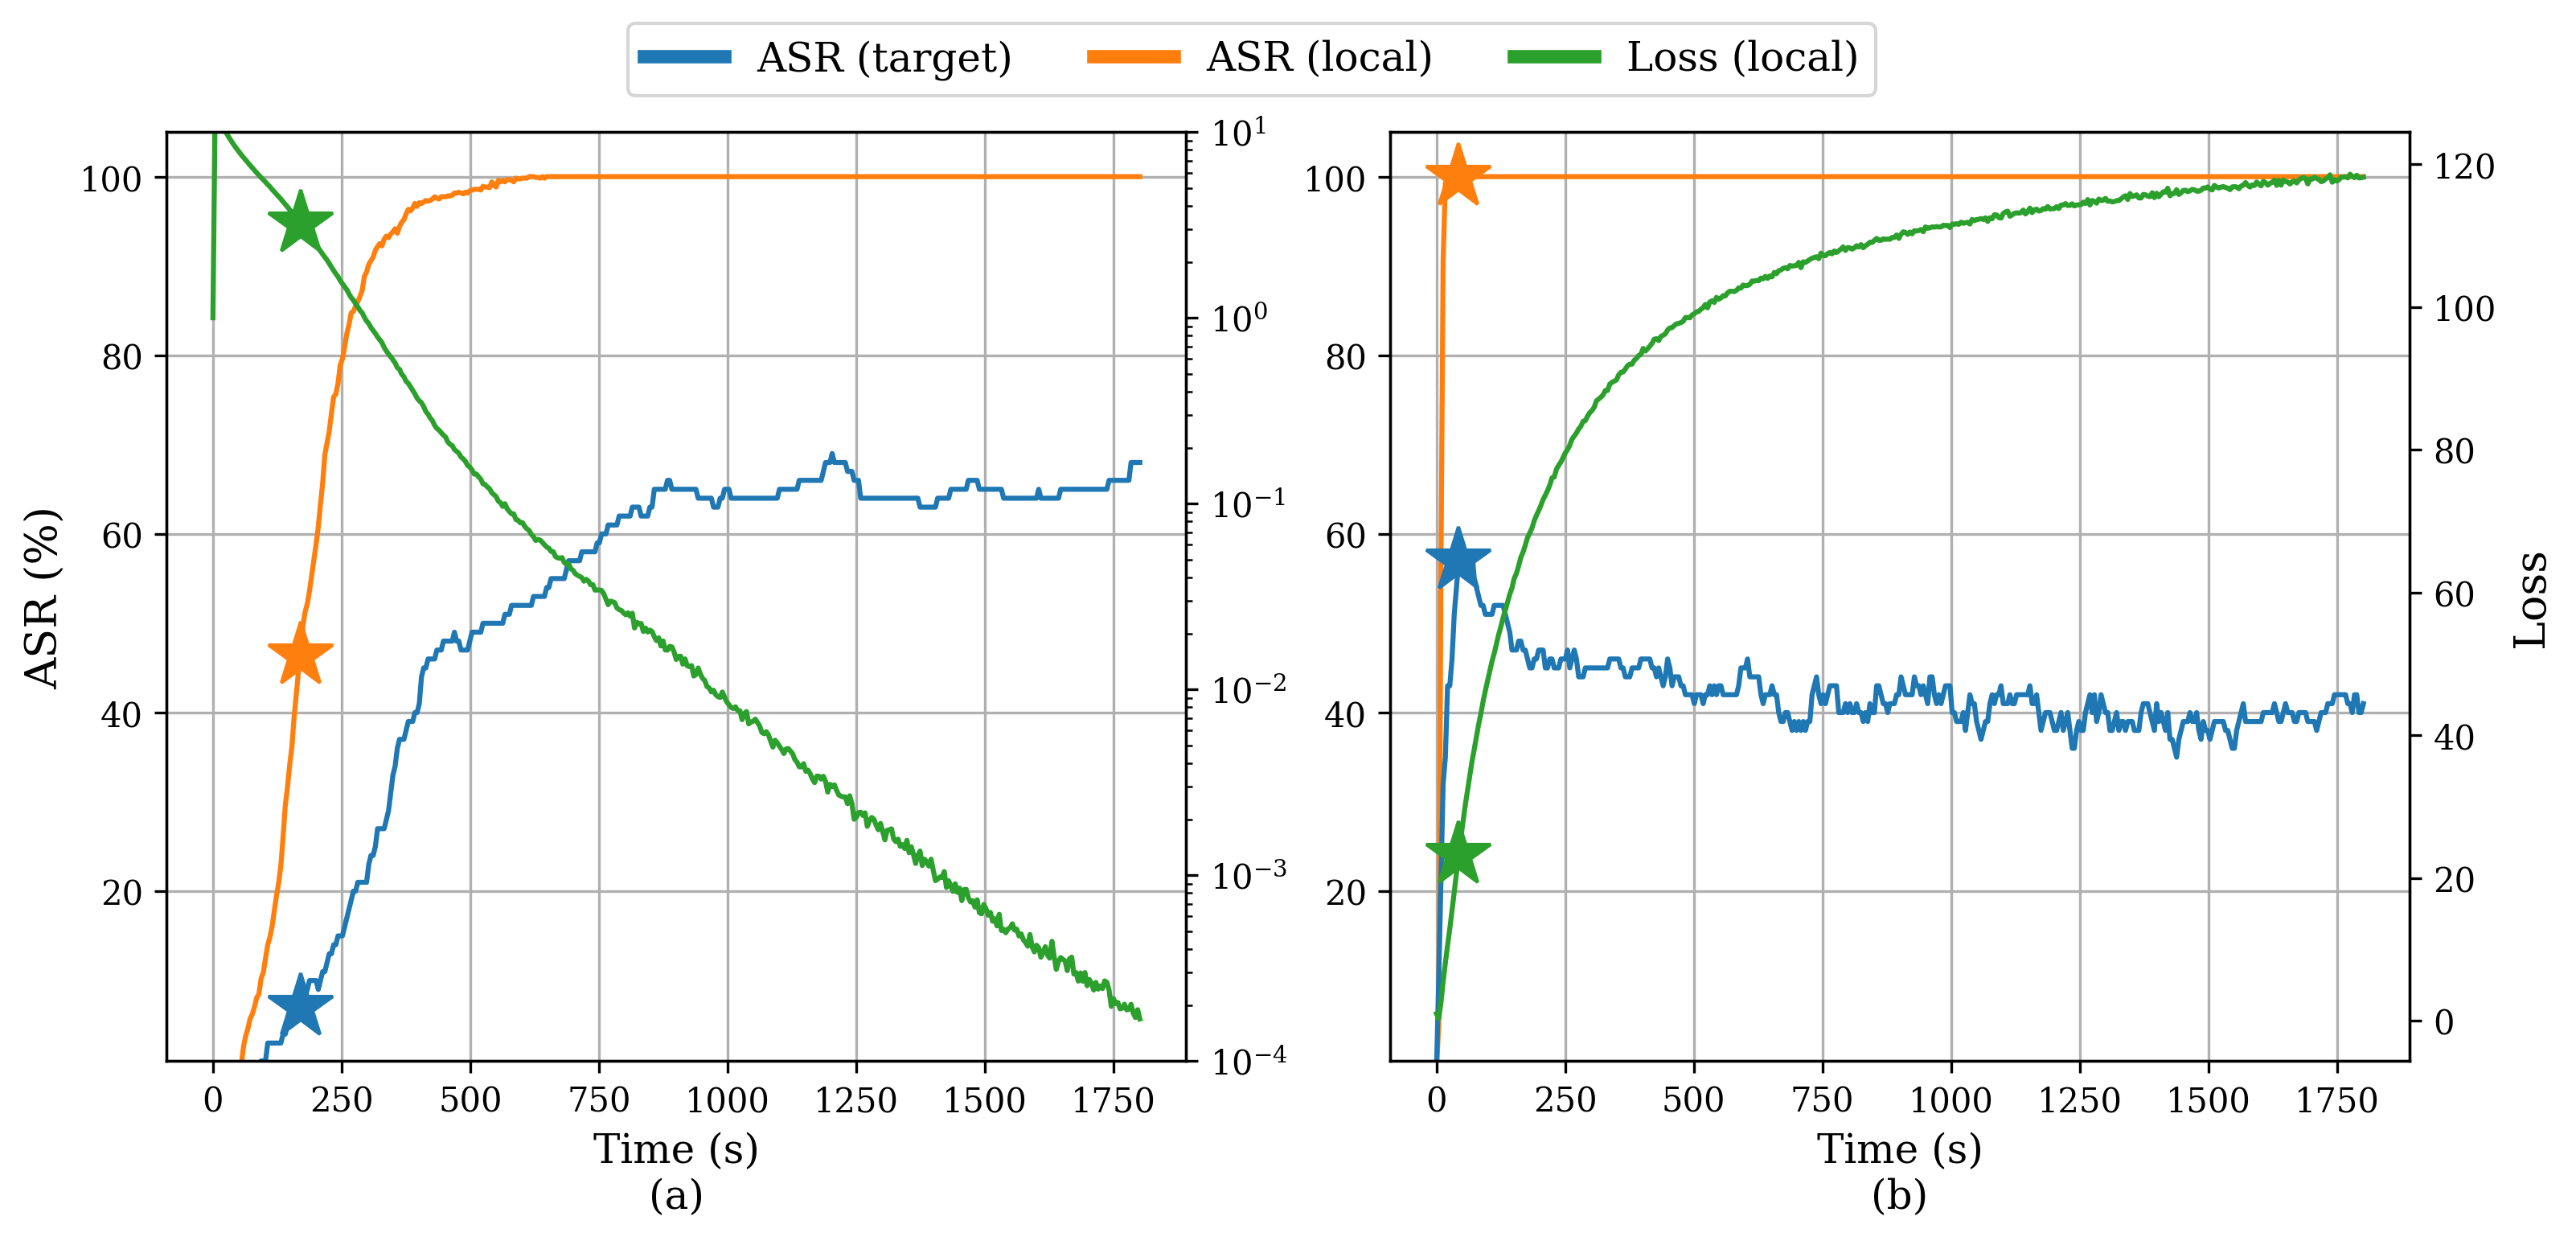

In [ ]:
plt.clf()
dir_path = '/content/drive/MyDrive/transfer results/local_metrics'

# Get a list of all the text files in the directory
txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

txt_files = txt_files[-2:]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# fig, axs = plt.subplots(1, 2, figsize=(24, 8)) # Previous (shorter now)
axs = axs.ravel()  # Flatten the axis array for easy indexing

colors = {
    'ASR (target)': 'C0',
    'ASR (local)': 'C1',
    'Loss (local)': 'C2'
}

# Loop through each text file and plot the data
for i, txt_file in enumerate(txt_files):
    print(txt_file)

    mark_point = N_ITER_UNTARGET if "_untarget_" in txt_file else N_ITER_TARGET

    # Get the average dictionary for the current file
    average_dict = process_file(os.path.join(dir_path, txt_file), local_metrics=True)

    # Plot local ASR
    plot(average_dict, axis=axs[i], use_markers=False, mark_iter=mark_point, legend=False, y_name='local_ASR', color=colors['ASR (local)'])

    # Plot ASR
    plot(average_dict, axis=axs[i], use_markers=False, mark_iter=mark_point, legend=False, color=colors['ASR (target)'])

    # Make a copy of axis (for loss)
    ax_new = axs[i].twinx()

    # Plot local loss
    plot(average_dict, axis=ax_new, use_markers=False, mark_iter=mark_point, legend=False, y_name='local_loss', initial_point_val=1, color=colors['Loss (local)'])

    # X-axis
    axs[i].set_xlabel('Time (s)', fontsize=12)
    ax_new.set_xlabel('Time (s)', fontsize=12)
    #axs[i].set_xscale('log')
    #ax_new.set_xscale('log')
    # Range
    axs[i].set_ylim(1, 105)
    # Y-axis
    if "_target_" in txt_file:
      ax_new.set_ylim(1e-4, 1e1)
      ax_new.set_yscale('log')
    # Grid
    axs[i].grid(True)

# Y-axis
axs[0].set_ylabel('ASR (%)', fontsize=13)
ax_new.set_ylabel('Loss', fontsize=13)
axs[0].set_title('(a)', y=-0.18)
ax_new.set_title('(b)', y=-0.18)

# Custom legend (since seaborn does not recognize clash and labels separately for same attack names)
legend_lines, legend_names = [], []
for k, v in colors.items():
  legend_lines.append(Line2D([0], [0], color=v, lw=4))
  legend_names.append(k)

# Space adjustment
plt.subplots_adjust(wspace=0.2, hspace=0)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 0.97),
              borderaxespad=0, ncol=11, fontsize=12)

savename = 'local_metrics_track'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/paper/{savename}.pdf', bbox_inches='tight')

## Figure 4: Attacks against targeted, robust models, and lower eps

<Figure size 1920x1440 with 0 Axes>

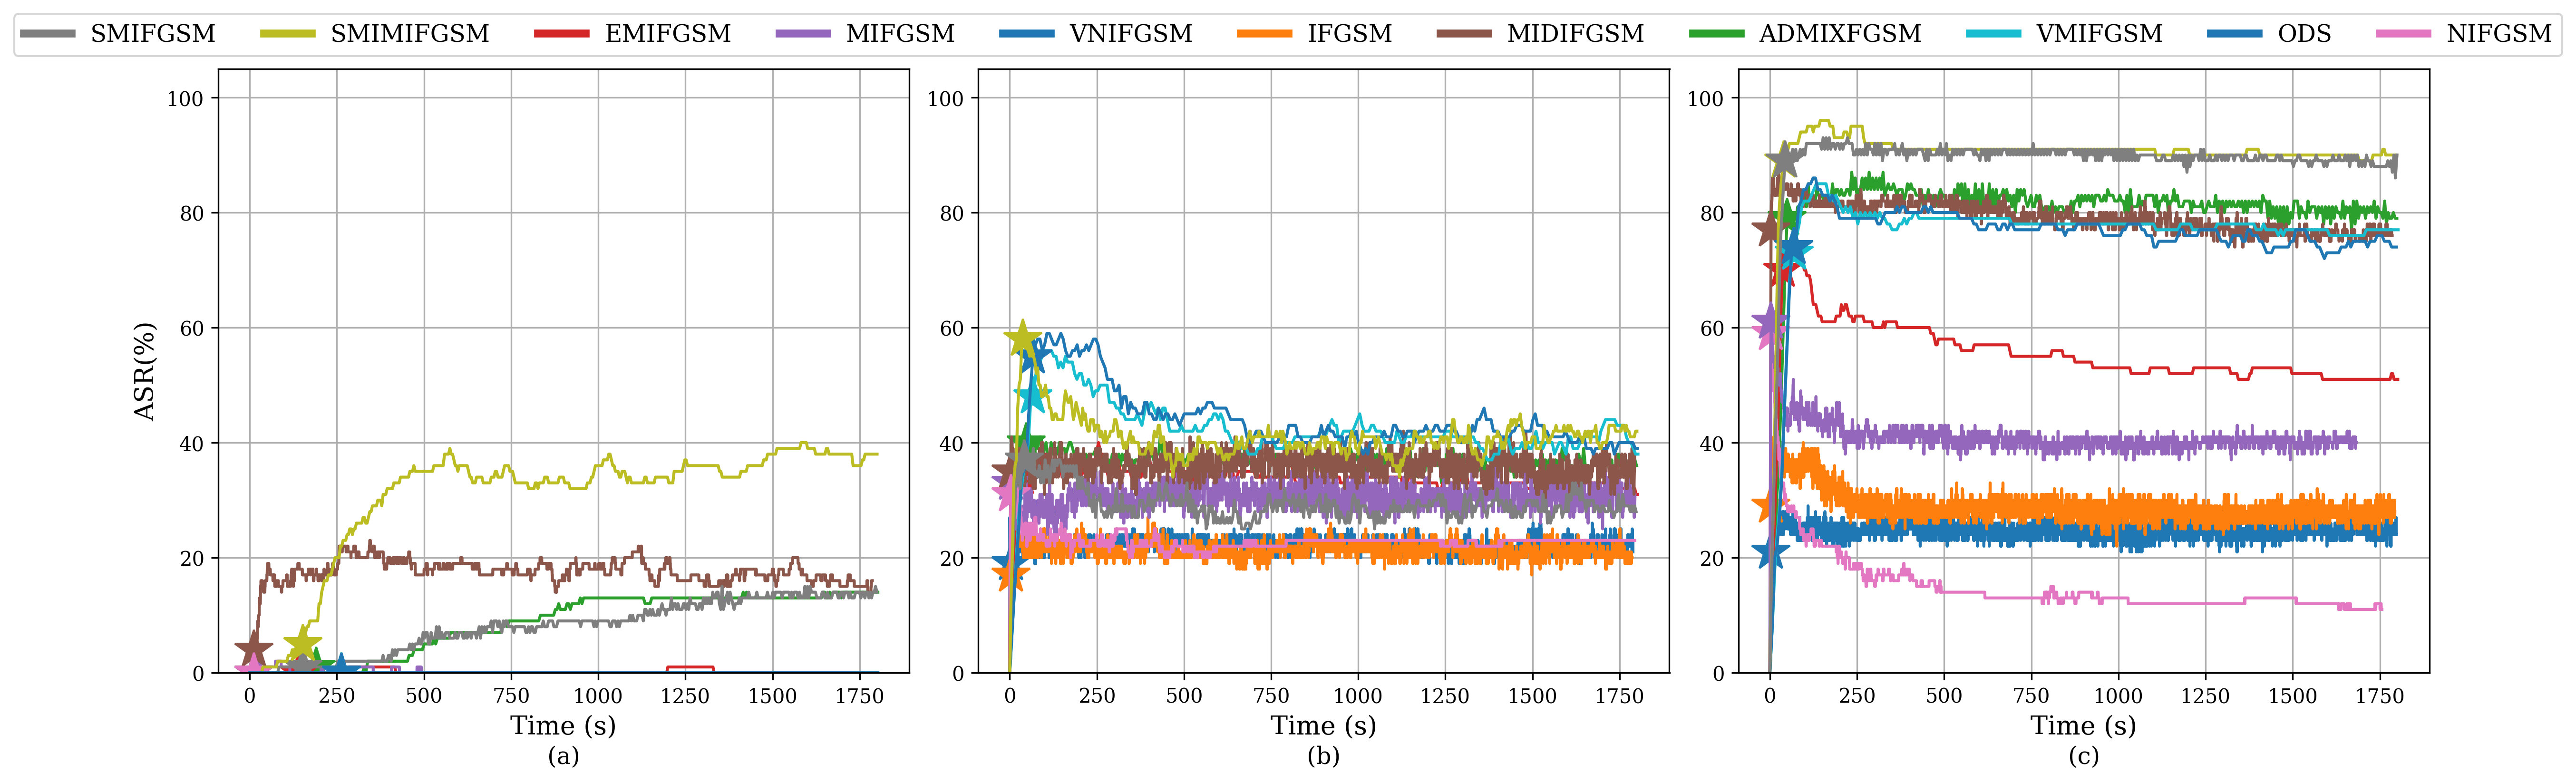

In [ ]:
plt.clf()
# dir_path = '/content/drive/MyDrive/transfer results/timed/untarget/ens_inception/'
dir_paths = [
    # '/content/drive/MyDrive/transfer results/untarget/inception/', # eps=16, untargeted
    '/content/drive/MyDrive/transfer results/timed/target/inception/', # eps=16, targeted
    '/content/drive/MyDrive/transfer results/timed/untarget/adv_inception/', # eps = 16, robust
    '/content/drive/MyDrive/transfer results/timed/untarget/inception/' # eps = 8
]

fig, axs = plt.subplots(1, len(dir_paths), figsize=(20, 5.5))
axs = axs.ravel()  # Flatten the axis array for easy indexing

names_seen = []
identifiers = ['(a)', '(b)', '(c)', '(d)']
for i, dir_path in enumerate(dir_paths):
  # Get a list of all the text files in the directory
  txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
  consistency_check(txt_files)

  # Loop through each text file and plot the data
  for txt_file in txt_files:
      # Keep track of attacks actually present
      names_seen.append(txt_file.split("_")[0])

      mark_point = N_ITER_UNTARGET if "_untarget_" in txt_file else N_ITER_TARGET

      # Get the average dictionary for the current file
      try:
          average_dict = process_file(os.path.join(dir_path, txt_file))
      except:
          average_dict = process_file(os.path.join(dir_path, txt_file), local_metrics=True)

      # Plot data (same time)
      plot(average_dict, axis=axs[i], use_markers=False, mark_iter=mark_point, across_time=True, legend=False)

      axs[i].set_xlabel('Time (s)', fontsize=13)
      axs[i].set_ylim(0, 105)
      # axs[i].set_xlim(0, 1800)
      axs[i].grid(True)
      axs[i].set_title(identifiers[i], y=-0.17)

axs[0].set_ylabel('ASR(%)', fontsize=13)

# Custom legend (since seaborn does not recognize clash and labels separately for same attack names)
names_seen = list(set(names_seen))
legend_lines, legend_names = [], []
for name in names_seen:
  legend_lines.append(Line2D([0], [0], color=ATTACK_COLOR_MAP[name], lw=4))
  legend_names.append(name)

# Space adjustment
plt.subplots_adjust(wspace=0.1, hspace=0)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 0.95),
              borderaxespad=0, ncol=11, fontsize=12)

savename = 'inception_target_vs_eps8_vs_adv'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/paper/{savename}.pdf', bbox_inches='tight')

## Figure 5: Query attacks

In [ ]:
dir_paths = [
    '/content/drive/MyDrive/transfer results/query result/hard label/',
    '/content/drive/MyDrive/transfer results/query result/full score/'
]

attack_names = []
for dir_path in dir_paths:
    txt_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]
    for txt_file in txt_files:
        attack_name = txt_file.split('_')[0]
        attack_names.append(attack_name)

color_map = sns.color_palette(n_colors=len(attack_names))
# Add it to ATTACK_COLOR_MAP
for i, name in enumerate(attack_names):
  ATTACK_COLOR_MAP[name] = color_map[i]

<Figure size 1920x1440 with 0 Axes>

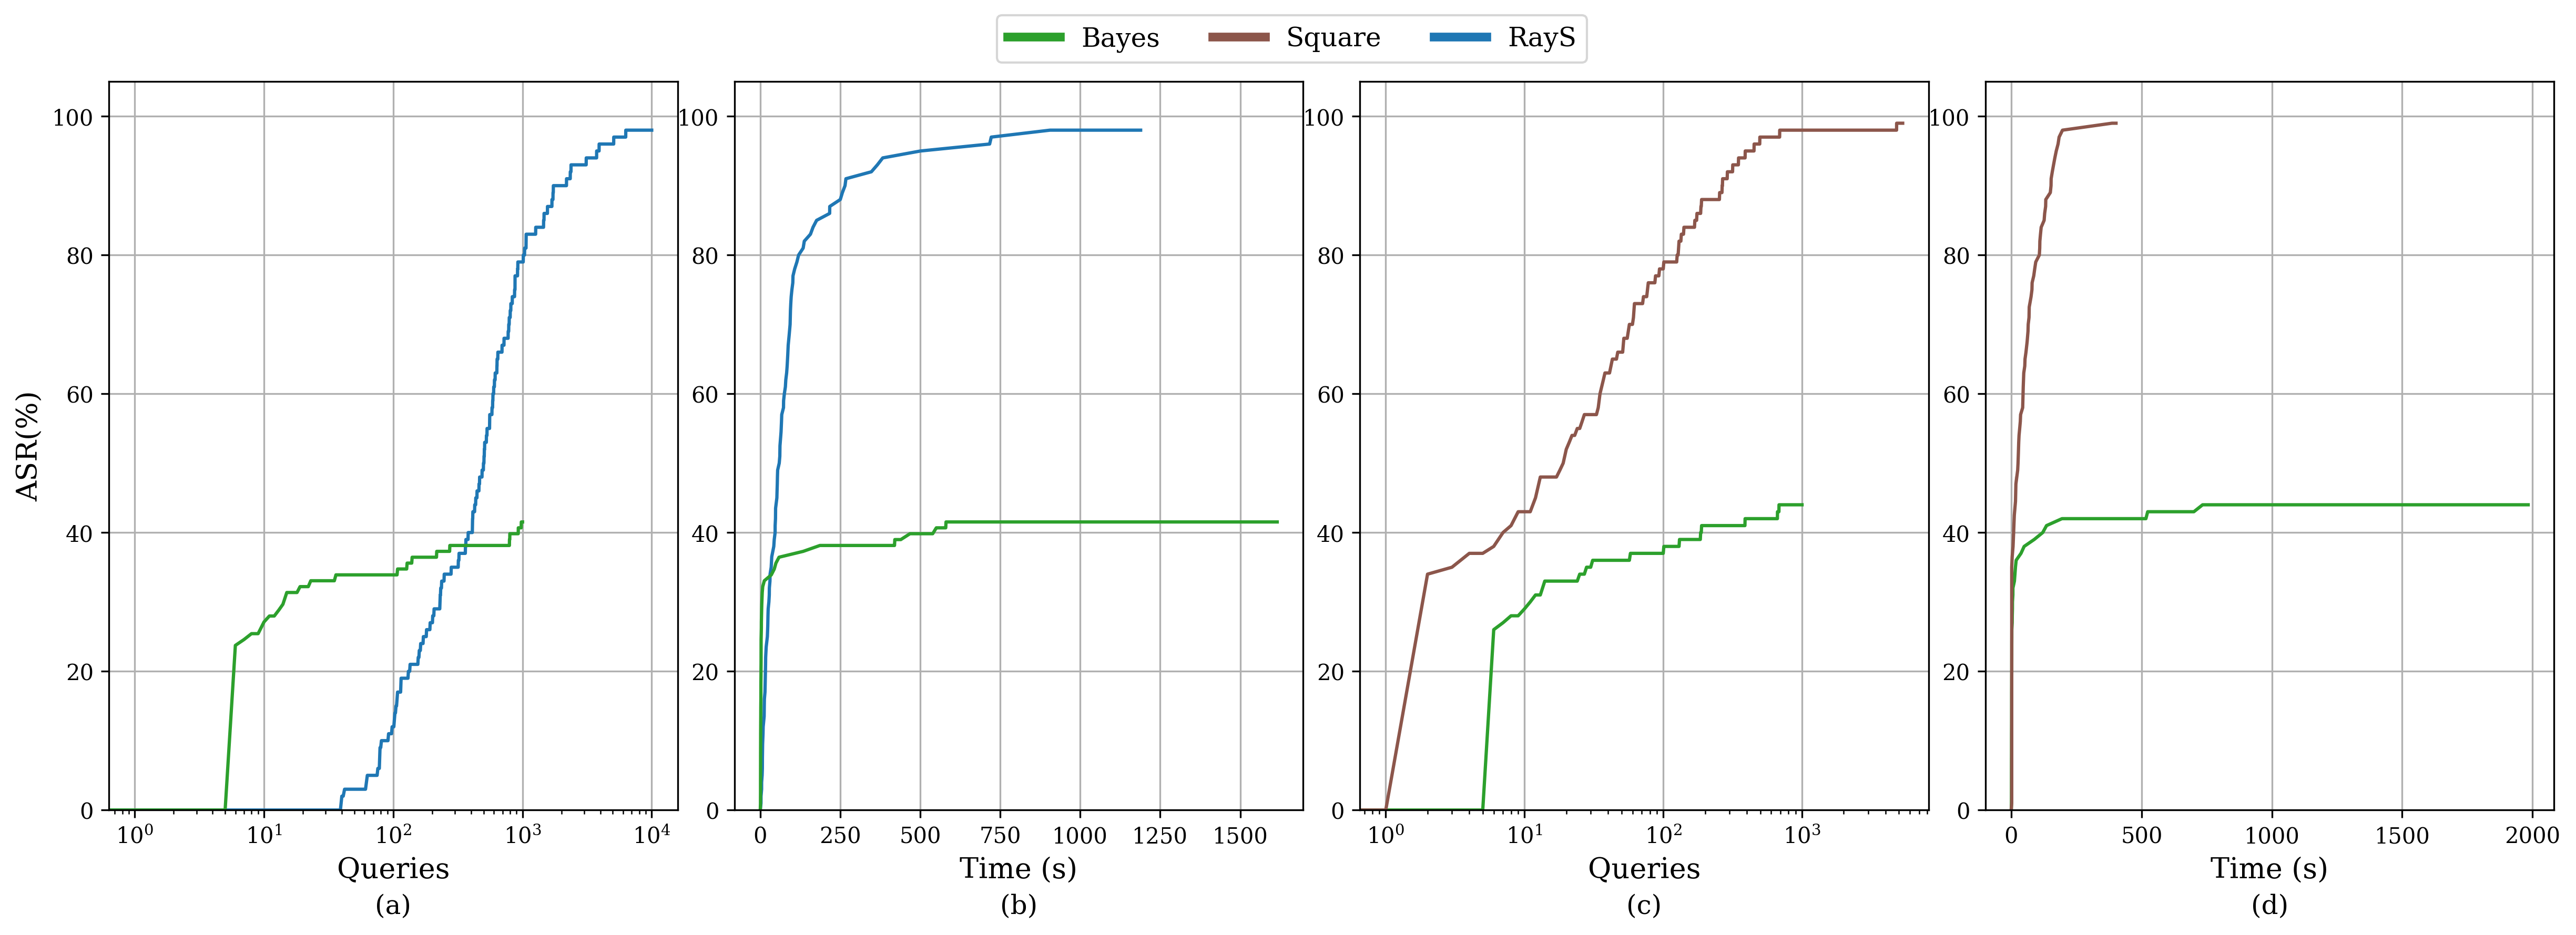

In [ ]:
plt.clf()

target_model = '_inceptionv3'
mode = '_untarget'

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs = axs.ravel()  # Flatten the axis array for easy indexing

names_seen = []

identifiers = ['(a)', '(b)', '(c)', '(d)']
for i, dir_path in enumerate(dir_paths):
    # Get a list of all the json files in the directory
    txt_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]

    # Loop through each text file and plot the data
    for txt_file in txt_files:
        if not (mode in txt_file and target_model in txt_file):
            continue

        # Keep track of attacks actually present
        names_seen.append(txt_file.split("_")[0])

        # Get the average dictionary for the current file (sorted by queries)
        average_dict = process_query_file(os.path.join(dir_path, txt_file), sort_by="queries")

        # Plot data (same queries)
        plot(average_dict, axis=axs[2 * i], use_markers=False, across_time=False, legend=False)

        # Get the average dictionary for the current file (sorted by time)
        average_dict = process_query_file(os.path.join(dir_path, txt_file), sort_by="time")

        # Plot data (same time)
        plot(average_dict, axis=axs[2 * i + 1], use_markers=False, across_time=True, legend=False, needs_time_sorting=True)

    # Setting labels
    axs[2 * i].set_xlabel('Queries', fontsize=13)
    axs[2 * i + 1].set_xlabel('Time (s)', fontsize=13)
    axs[0].set_ylabel('ASR(%)', fontsize=13)

    # Same ASR range
    axs[2 * i].set_ylim(0, 105)
    axs[2 * i + 1].set_ylim(0, 105)
    axs[2 * i].grid(True)
    axs[2 * i + 1].grid(True)

    # Bottom label
    axs[2 * i].set_title(identifiers[2 * i], y=-0.16)
    axs[2 * i + 1].set_title(identifiers[2 * i + 1], y=-0.16)

    # Log scale for queries
    axs[2 * i].set_xscale('log')


# Unique names
names_seen = list(set(names_seen))

# Custom legend (since seaborn does not recognize clash and labels separately for same attack names)
legend_lines, legend_names = [], []
for name in names_seen:
  legend_lines.append(Line2D([0], [0], color=ATTACK_COLOR_MAP[name], lw=4))
  legend_names.append(name)

# Space adjustment
plt.subplots_adjust(wspace=0.1, hspace=0)

# Legend plot
plt.figlegend(legend_lines, legend_names,
             loc='upper center', bbox_to_anchor=(0.5, 0.95),
             borderaxespad=0, ncol=11, fontsize=12)

savename = 'appendix_query_based'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/paper/{savename}.pdf', bbox_inches='tight')

## Appendix Figures

<Figure size 1920x1440 with 0 Axes>

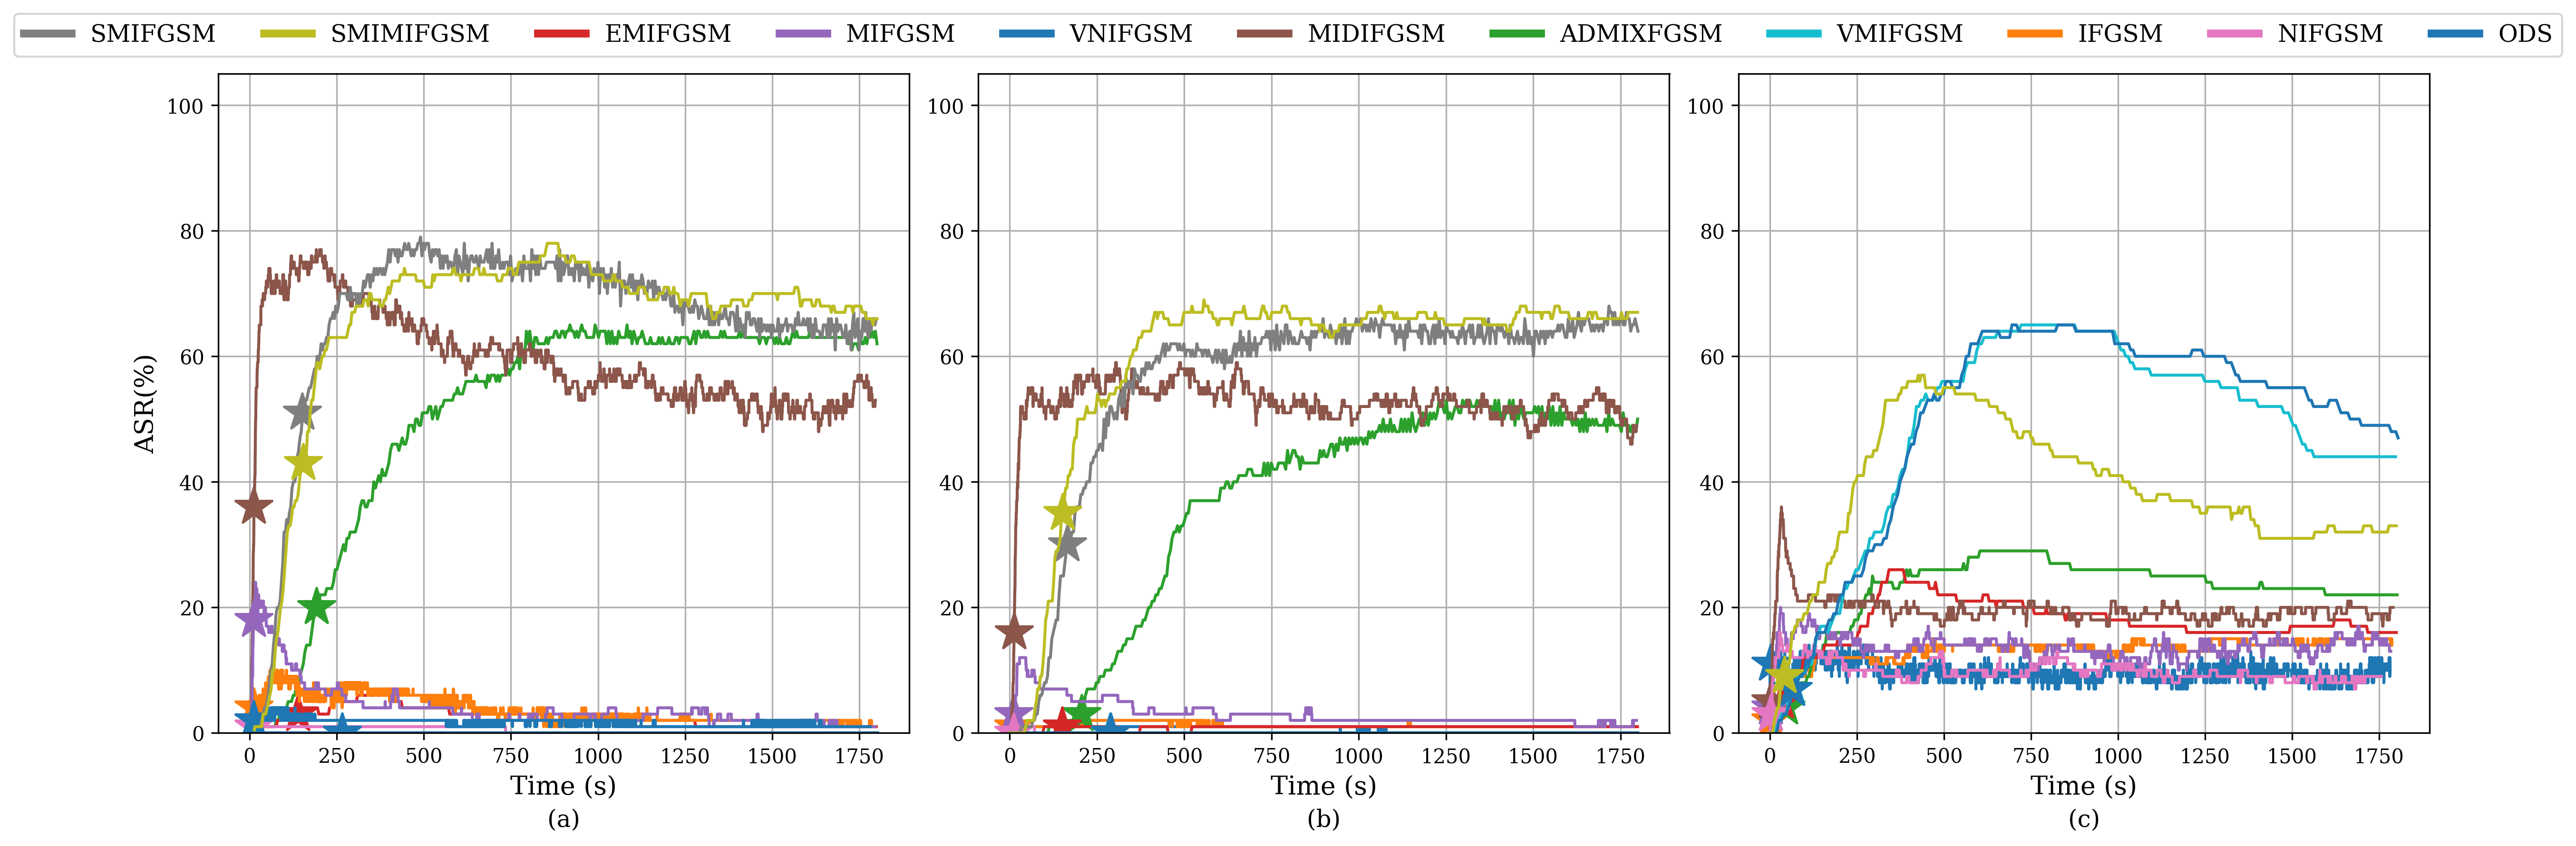

In [ ]:
plt.clf()
dir_paths = [
    '/content/drive/MyDrive/transfer results/timed/target/vgg/', # eps=16, targeted
    '/content/drive/MyDrive/transfer results/timed/target/resnet/', # eps=16, targeted
    '/content/drive/MyDrive/transfer results/timed/untarget/ens_inception/' # eps=16, untargeted
]

fig, axs = plt.subplots(1, len(dir_paths), figsize=(20, 6))
axs = axs.ravel()  # Flatten the axis array for easy indexing

names_seen = []
identifiers = ['(a)', '(b)', '(c)']
for i, dir_path in enumerate(dir_paths):
  # Get a list of all the text files in the directory
  txt_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
  consistency_check(txt_files)

  # Loop through each text file and plot the data
  for txt_file in txt_files:
      # Keep track of attacks actually present
      names_seen.append(txt_file.split("_")[0])

      mark_point = N_ITER_UNTARGET if "_untarget_" in txt_file else N_ITER_TARGET

      # Get the average dictionary for the current file
      try:
          average_dict = process_file(os.path.join(dir_path, txt_file))
      except:
          average_dict = process_file(os.path.join(dir_path, txt_file), local_metrics=True)

      # Plot data (same time)
      plot(average_dict, axis=axs[i], use_markers=False, mark_iter=mark_point, across_time=True, legend=False)

      axs[i].set_xlabel('Time (s)', fontsize=13)
      axs[i].set_ylim(0, 105)
      # axs[i].set_xlim(0, 1800)
      axs[i].grid(True)
      axs[i].set_title(identifiers[i], y=-0.16)

axs[0].set_ylabel('ASR(%)', fontsize=13)

# Custom legend (since seaborn does not recognize clash and labels separately for same attack names)
names_seen = list(set(names_seen))
legend_lines, legend_names = [], []
for name in names_seen:
  legend_lines.append(Line2D([0], [0], color=ATTACK_COLOR_MAP[name], lw=4))
  legend_names.append(name)

# Space adjustment
plt.subplots_adjust(wspace=0.1, hspace=0)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 0.95),
              borderaxespad=0, ncol=11, fontsize=12)

savename = 'appendix_vgg_resnet_ens'
plt.savefig(f'/content/drive/MyDrive/transfer results/plots/paper/{savename}.pdf', bbox_inches='tight')

## Statistics for Table 2

In [ ]:
fpath = '/content/drive/MyDrive/transfer results/query result/full score/Hybrid_eps_16_resnet50.json'
# fpath = '/content/drive/MyDrive/transfer results/query result/full score/Square_eps_16_target_inceptionv3.json'
average_dict = process_query_file(fpath, sort_by="queries")

In [ ]:
all = list(average_dict.values())
print(all[-1]['ASR'], list(average_dict.keys())[-1])

98.78048780487805 1714
